In [43]:
!date

import seaborn as sb
import pandas as pd
import numpy as np
import os
from numpy import fft
from scipy import signal
import quickspikes as qs
import matplotlib as mpl
from matplotlib import lines
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as tk
import matplotlib.patches as patches
import bootstrapContrast as bs
%matplotlib inline

threshold = 2.58 # This is the scaled threshold, in SD of the signal.
                 # Change as appropriate for plotting and analysis.

# Sample rate. MUST BE SAME ACROSS ALL NERVE RECORDINGS.
fs = 10000.0       

lightCol = 'lightgreen' # color of light pulse, for plotting on spike plots and raster plots.
dpi = 250 # dpi of figures.

sb.set_style('ticks')
plt.rcParams['svg.fonttype'] = 'none' # Ensures the text in figures are not lines but text.
mpl.rcParams['agg.path.chunksize'] = 10000 
# Mitigates this error: https://github.com/matplotlib/matplotlib/issues/5907

# Read in led protocols from pickled data. Very fast.
led1pro = pd.read_pickle('/Users/jacuzzijo/Google Drive/ACC Lab/ACR/Larval nerve ephys/Expt Info Spreadsheets/led1pro.pickle')
led30pro = pd.read_pickle('/Users/jacuzzijo/Google Drive/ACC Lab/ACR/Larval nerve ephys/Expt Info Spreadsheets/led30pro.pickle')
exptInfo = pd.read_pickle('/Users/jacuzzijo/Google Drive/ACC Lab/ACR/Larval nerve ephys/Expt Info Spreadsheets/exptInfo.pickle')

# Identify light change indexes, add into a dictionary.
lightChangeProtocols = {'LED1' : np.where(np.diff(led1pro['LED1']) != 0)[0]+1,
                        'LED 30s' : np.where(np.diff(led30pro['LED 30s']) != 0)[0]+1
                       }

# Define formatting functions.
def to_seconds_int(t, pos):
    '''Converts 10kHz timestamp into integer seconds.'''
    sec = t/10000
    return str(int(sec))
def to_seconds_float(t, pos):
    '''Converts 10kHz timestamp into float seconds.'''
    sec = t/10000
    return str(sec)

Tue Oct 18 16:39:19 SGT 2016


In [97]:
lightChangeProtocols['LED1']

array([31562, 36562, 56562, 61562, 81562, 86562])

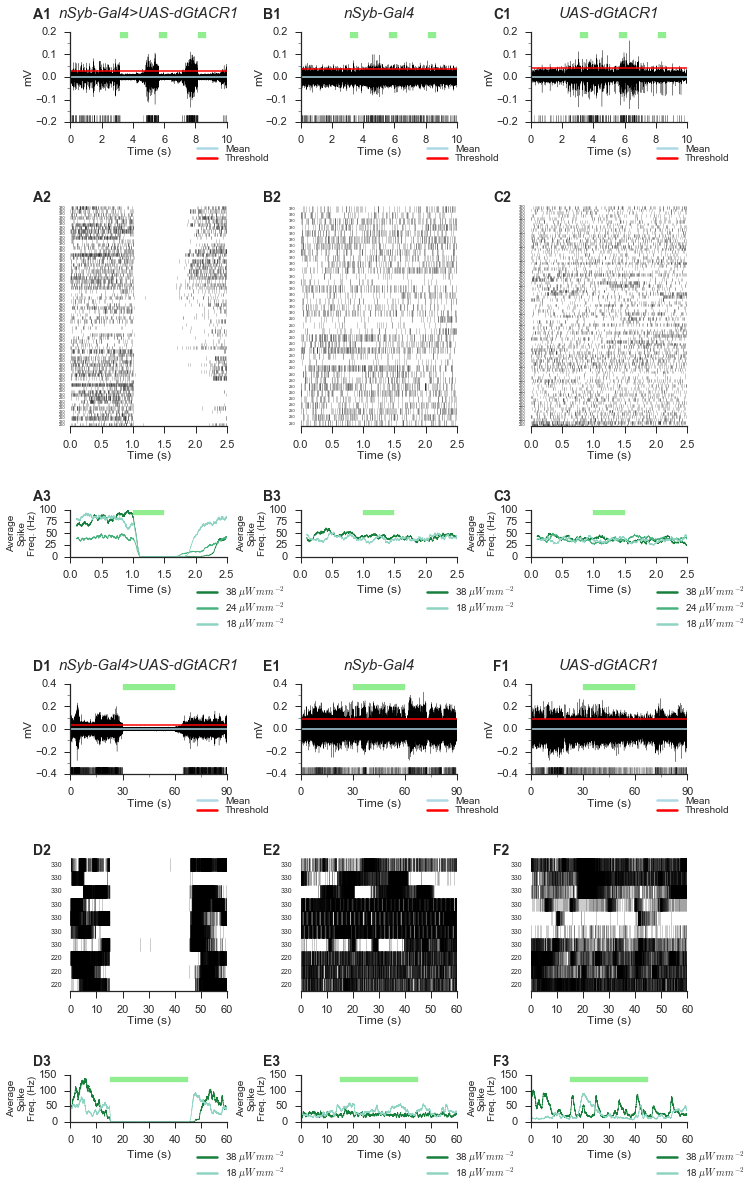

In [95]:
fsize = (11,17) # xy in inches.
fig = plt.figure(figsize = fsize)
g = gs.GridSpec(28, 11) # number of rows, then number of columns.

# Create dictionary to map LED elevation to light intensity
mmToW = {220: '38',
         280: '24',
         330: '18'}
genoOrder = list()

# Create lists to store the axes.
exemplarsArray500ms = list()
stackedArray500ms = list()
frequencyArray500ms = list()

exemplarsArray30s = list()
stackedArray30s = list()
frequencyArray30s = list()

files500 = ['16925065_Trace #1 (mV)_LED1_220mm_nSyb-Gal4>UAS-dGtACR1_larva2_seg3_bandpassFiltered_100-1500Hz',
            '16926000_Trace #1 (mV)_LED1_330mm_nSyb-Gal4_larva1_seg4_bandpassFiltered_100-1500Hz',
            '16719045_Trace #1 (mV)_LED1_280mm_UAS-dGtACR1_larva1_segmentUnknown_bandpassFiltered_100-1500Hz',
   ]
files30 = [ '16925071_Trace #1 (mV)_LED 30s_220mm_nSyb-Gal4>UAS-dGtACR1_larva2_seg3_bandpassFiltered_100-1500Hz',
           '16926008_Trace #1 (mV)_LED 30s_220mm_nSyb-Gal4_larva1_seg4_bandpassFiltered_100-1500Hz',
           '16925018_Trace #1 (mV)_LED 30s_330mm_UAS-dGtACR1_larva1_seg4_bandpassFiltered_100-1500Hz',
        ]

for i, file in enumerate(files500):
    ix = (i * 3) + 1
    a = plt.subplot( g[0:3, ix:ix+3] )
    exemplarsArray500ms.append(a)
for i, x in enumerate(files500):
    ix = (i * 3) + 1
    a = plt.subplot( g[4:10, ix:ix+3] )
    b = plt.subplot( g[11:13, ix:ix+3] )
    stackedArray500ms.append(a)
    frequencyArray500ms.append(b)
    
for i, file in enumerate(files30):
    ix = (i * 3) + 1
    a = plt.subplot( g[15:18, ix:ix+3] )
    exemplarsArray30s.append(a)
for i, x in enumerate(files30):
    ix = (i * 3) + 1
    a = plt.subplot( g[19:23, ix:ix+3] )
    b = plt.subplot( g[24:26, ix:ix+3] )
    stackedArray30s.append(a)
    frequencyArray30s.append(b)

########## Exemplary Traces 500ms
datadir = '/Users/jacuzzijo/Google Drive/ACC Lab/ACR/Larval nerve ephys/data/500ms_pulse/'
atfdir = datadir+'atf/raw/'
# Make sure we are reading from the correct folders.
tracedir = datadir + 'atf/bandpass_filtered/'
spikedir = datadir + 'threshold_'+str(threshold)+'_SD/spikes/npy_files/'
# Intialise a list to store the order of the genotypes (as determined by the order in `files`) so we can 
# properly match the genotype order later for the raster plots and the contrast plots.
for i, file in enumerate(files500):
    # Read in the npy file.
    trace = np.load(tracedir+file+'.npy')
    # Read in the spike_idx file.
    spike_idx = np.load(spikedir+file+'_spikes--WindowSize500--ScaledThresholdSD2.58.npy')
    # Read in the correct protocol from the filename.
    protocol = file.split('_')[2]
    # Read and save the genotype order.
    title = file.split('_')[4]
    genoOrder.append(title)
    # Get light epochs from exptInfo.
    lightChangeIdx = lightChangeProtocols[ protocol ]
    # Plot the entire trace.
    pd.Series(trace).plot( ax = exemplarsArray500ms[i], 
                          color = 'k', 
                          linewidth = 0.25, 
                          label = '_nolegend_' )
    # Plot each spike as rugplot at the bottom of the axes.
    for spike in spike_idx:
        exemplarsArray500ms[i].axvline(x = spike, 
                                       ymax = 0.075, # the height of the rugtick will be this fraction of the plot.
                                       color = 'k', 
                                       linewidth = 0.5,
                                       alpha = 0.5)

    # Prepare y-axis for plotting of lightOn pulse rectangles.
    # Set the view interval manually.
    maxY = 0.2
    exemplarsArray500ms[i].set_ylim(-maxY, maxY)
    # Get the tick interval for proportional rug-plotting, and for re-drawing the ticks.
    tickInt = 0.05
#     tickInt = axarr[i].yaxis.get_ticklocs()[1] - axarr[i].yaxis.get_ticklocs()[0]
    
    # Loop thru each light pulse and draw a rectangle for each pulse.
    for n, idx in enumerate(np.arange(0, len(lightChangeIdx), 2)):
        pulseNum = str(n+1)
        # For each pulse, extract the pulse length
        pulseLengthIdx = lightChangeIdx[idx+1] - lightChangeIdx[idx]
        pulseLengthSec = pulseLengthIdx/fs

        # Draw the rectangle for this pulse.
        exemplarsArray500ms[i].add_patch(
            patches.Rectangle(
                ( lightChangeIdx[idx], maxY-(tickInt/2) ),   # xy coords of left most corner of rect
                pulseLengthIdx,       # width of rect.
                tickInt/2,            # height of rect
                color = lightCol
                )
            )

    # Draw red line to indicate mean
    exemplarsArray500ms[i].axhline(y = np.mean(trace), lw = 1.5, color = 'lightblue', label = 'Mean')
    # Draw red line to indicate the spike threshold.
    # Threshold should have been defined in cell above; double-check with filename...
    exemplarsArray500ms[i].axhline(y = threshold * np.std(trace), lw = 1.5, color = 'red', label = 'Threshold')
    
    # Aesthetic tweaks.
    # Make sure the x-axis is in seconds.
    exemplarsArray500ms[i].set_xlim(0, 100100.)
    exemplarsArray500ms[i].xaxis.set_major_formatter(FuncFormatter(to_seconds_int))
    # Re-set the yticks to minimise the clutter.
    # Initialise tick locators.
    majorLocator = tk.FixedLocator( [-0.2, -0.1, 0, 0.1, 0.2] )
    exemplarsArray500ms[i].yaxis.set_major_locator(majorLocator)
    exemplarsArray500ms[i].yaxis.set_minor_locator( tk.AutoMinorLocator(n = 2) )
    # Set font sizes and labels for the axes, titles, and ticks.
    tt = exemplarsArray500ms[i].set_title(title, fontsize = 15, style = 'italic')
    tt.set_position([.5, 1.1]) # tweak the second number to adjust the vertical spacing between the title and axes.
    
    ylab = exemplarsArray500ms[i].set_ylabel('mV', fontsize = 12, labelpad = 2)
    ylab.set_position([-1.05, .5, ]) # tweak the second number to adjust the vertical spacing between the title and axes.
    
    xlab = exemplarsArray500ms[i].set_xlabel('Time (s)', fontsize = 12, labelpad = 2)
    xlab.set_position([.5, -1.05]) # tweak the second number to adjust the vertical spacing between the title and axes.
    
    exemplarsArray500ms[i].tick_params(axis='both', which='major', labelsize = 11, length = 6, pad = 2)
    exemplarsArray500ms[i].tick_params(axis='y', which='minor', length = 3)
    # `length` is the length of the tick extending from the axis; 
    # `pad` is the distance between the tick and its label.
    
    # Despine the axis.
    sb.despine(ax = exemplarsArray500ms[i])

######### Stacked Rasters 500ms
# Below variables are hardcoded for ease, for now.
rollingAvBinSize = 1000 # this is the window size. Divide by fs to get this in seconds.
pulseLengthSec = 0.5
pulseLengthIdx = int(pulseLengthSec*fs)
# Define the before and after padding, in terms of multiples of the light pulse.
# This CANNOT be less than 0.
beforePad = 2
afterPad = 2
rasterSpanIdx = pulseLengthIdx + beforePad*pulseLengthIdx + afterPad*pulseLengthIdx
# Input in this cell all the indices that you want to remove from raster plotting and analysis..
dropList = [129, 39, 38, 138, 108, 109, 110, 142, 143, 132, 139,    # UAS-dGtACR1
            289, 290, 295, 294, 293, 292, 296, 288, 291,            # nSyb-Gal4
            297, 298, 299, 300, 301, 302, 303, 304, 305, 
            158, 153, 154, 155, 0,  1, 2, 3, 4, 5, 9,                # Mutants
            10, 11, 12, 13, 14, 15, 16, 17, 165, 166, 167, 161, 197
           ]
workdir = datadir + 'threshold_'+str(threshold)+'_SD/'
rasters = pd.read_pickle(workdir+'rasters_'+str(threshold)+'_SD.pickle')
rasters = rasters.drop(dropList, axis = 0)
rasters = rasters[rasters['illumination_mm'] != 110]
# Create the light illumination palette.
illumPalKeys = np.sort( rasters['illumination_mm'].unique() )
illumPalvalues = sb.color_palette( "BuGn_r", 4 )[0:3]
illumPal = dict(zip(illumPalKeys, illumPalvalues))

for ix, genotype in enumerate(genoOrder):
    yticklocs = list()
    yindex = list()
    # Make sure genoOrder has been defined when generating the exemplary plots.
    # Filter the data and sort it.
    tempdf = rasters[(rasters['genotype'] == genotype)].sort_values( by = 'illumination_mm' )
    
    illumMeanDict = dict()
    illumCIWidthDict = dict()
    for e, lev in enumerate(tempdf['illumination_mm'].unique()):
        # filter by illumination level.
        tempdf_byIllum = tempdf[tempdf['illumination_mm'] == lev]
        # Set up lists to capture the rolling plots.
        avSpikeFreq = list()
        # loop thru each row of tempIdx and pull out the spike indices for each combined epoch.
        for i in tempdf_byIllum.index:
            spikeIdx = tempdf_byIllum.ix[i,'spikeIndices']
            # Make a temp Series, assign all values as 0.
            spikePos = pd.Series( np.repeat(0, rasterSpanIdx) )
            spikePos[spikeIdx] = 1
            # Calculate spike frequency in rolling windows.
            spikeFreq = spikePos.rolling(rollingAvBinSize).sum() / (rollingAvBinSize/fs)
            avSpikeFreq.append(spikeFreq)
        # Turn the list into a nice DataFrame, calculate the 
        df = pd.DataFrame(avSpikeFreq)
        meanSpikeFreq = df.mean()
        ciWidth = df.std() * 1.96
        # Then store into dicts for later plotting.
        illumMeanDict[lev] = meanSpikeFreq
        illumCIWidthDict[lev] = ciWidth
        
    # Calculate the height of each raster.
    ymin = 1/len(tempdf)
    # Loop thru each spike index and plot it.
    for i, raster in enumerate(tempdf['spikeIndices']):
        for spike in raster:
            stackedArray500ms[ix].axvline(x = spike,
                                       linewidth = 0.5,
                                       ymin = ymin * (i),     # both ymin and ymax are in terms of figure fractional height.
                                       ymax = ymin * (i+1), 
                                       color = 'k', 
                                       alpha = 0.4)
        # Save the index for label assignment.
        yticklocs.append((ymin * i) + ymin/2)
    # Set x-axis label.
    xlab = stackedArray500ms[ix].set_xlabel('Time (s)', fontsize = 12, labelpad = 1)
    # Set the y-tick locations.
    stackedArray500ms[ix].set_yticks(yticklocs)
    # Set the ytick labels and font size.
    stackedArray500ms[ix].set_yticklabels(tempdf['illumination_mm'], fontsize = 5)
    
    # Plot average spike frequency, for each illumination level.
    for lev in np.sort(list(illumMeanDict.keys())):
        freq = illumMeanDict[lev]
        ciwidth = illumCIWidthDict[lev]
        freqPlot = freq.plot( ax = frequencyArray500ms[ix], 
                             color = illumPal[lev], 
                             linewidth = 0.75,
                             label = mmToW[lev] + ' ' + r'$\mu W \/ mm^{-2}$' )
        
for ix, j in enumerate(stackedArray500ms):
    # make sure the xlimit spans over all the epochs.
    j.set_xlim(0, rasterSpanIdx)
    # Format the tick labels.
    j.tick_params(axis='y', which='major', labelsize = 4, length = 0, pad = 1)
    j.tick_params(axis='x', which='major', labelsize = 11, length = 7)
    j.xaxis.set_major_formatter(FuncFormatter(to_seconds_float))
    # Despine for aesthetics.
    sb.despine(ax = j, left = True)

# Loop thru all frequency arrays and pull out their maximum ylims.
maxYs = list()
for k in frequencyArray500ms:
    maxYs.append(k.yaxis.get_view_interval()[1])

for ix, k in enumerate(frequencyArray500ms):
    # Make sure the x-axis is in seconds, and label it as such.
    k.set_xlim(0, 25005.)
    k.xaxis.set_major_formatter(FuncFormatter(to_seconds_float))
    xlab = k.set_xlabel('Time (s)', fontsize = 12)
    # Make sure the y-axis of the summed raster plot starts from 0, and label it appropriately.
    k.yaxis.set_view_interval( 0, np.max(maxYs) )
    # indicate the LightOn pulse with a rectangle at the top of the plot.
    maxY = np.max(maxYs)
    ytickinterval = k.yaxis.get_ticklocs()[1] - k.yaxis.get_ticklocs()[0]
    k.add_patch(
        patches.Rectangle(
            ( (pulseLengthSec*beforePad)*fs, maxY - ytickinterval/2 ),   # xy coords of left most corner of rect
            pulseLengthSec*fs,    # width of rect.
            ytickinterval,      # height of rect.
            color = lightCol
        )
    )
#     if ix != 0:
#         k.set_ylabel('')
#         k.set_yticklabels([])
#    else:
    k.set_ylabel('Average\nSpike\nFreq. (Hz)', fontsize = 10, labelpad = 2)
    # Manually tweak y-axis.
    k.yaxis.set_major_locator(tk.MultipleLocator(25))
    # Axis tick parameters.
    k.tick_params(axis='both', which='major', labelsize = 11, length = 6, pad = 2)
    k.tick_params(axis='y', which='minor', length = 3)
    # Despine for aesthetics.
    sb.despine(ax = k)
    
########## Exemplary Traces 30s
genoOrder = list()
datadir = '/Users/jacuzzijo/Google Drive/ACC Lab/ACR/Larval nerve ephys/data/30s_pulse/'
atfdir = datadir+'atf/raw/'
# Make sure we are reading from the correct folders.
tracedir = datadir + 'atf/bandpass_filtered/'
spikedir = datadir + 'threshold_'+str(threshold)+'_SD/spikes/npy_files/'
# Intialise a list to store the order of the genotypes (as determined by the order in `files`) so we can 
# properly match the genotype order later for the raster plots and the contrast plots.
for i, file in enumerate(files30):
    # Read in the npy file.
    trace = np.load(tracedir+file+'.npy')
    # Read in the spike_idx file.
    spike_idx = np.load(spikedir+file+'_spikes--WindowSize500--ScaledThresholdSD2.58.npy')
    # Read in the correct protocol from the filename.
    protocol = file.split('_')[2]
    # Read in and save the genotype order.
    title  = file.split('_')[4]
    genoOrder.append(title)
    # Get light epochs from exptInfo.
    lightChangeIdx = lightChangeProtocols[ protocol ]
    # Plot the entire trace.
    pd.Series(trace).plot( ax = exemplarsArray30s[i], 
                          color = 'k', 
                          linewidth = 0.25,
                          label = '_nolegend_' )
    # Plot each spike as rugplot at the bottom of the axes.
    for spike in spike_idx:
        exemplarsArray30s[i].axvline(x = spike, 
                                       ymax = 0.075, # the height of the rugtick will be this fraction of the plot.
                                       color = 'k', 
                                       linewidth = 0.5,
                                       alpha = 0.15)

    # Prepare y-axis for plotting of lightOn pulse rectangles.
    # Set the view interval manually.
    maxY = 0.4
    exemplarsArray30s[i].set_ylim(-maxY, maxY)
    # Get the tick interval for proportional rug-plotting, and for re-drawing the ticks.
    tickInt = 0.1
#     tickInt = axarr[i].yaxis.get_ticklocs()[1] - axarr[i].yaxis.get_ticklocs()[0]
    
    # Loop thru each light pulse and draw a rectangle for each pulse.
    for n, idx in enumerate(np.arange(0, len(lightChangeIdx), 2)):
        pulseNum = str(n+1)
        # For each pulse, extract the pulse length
        pulseLengthIdx = lightChangeIdx[idx+1] - lightChangeIdx[idx]
        pulseLengthSec = pulseLengthIdx/fs

        # Draw the rectangle for this pulse.
        exemplarsArray30s[i].add_patch(
            patches.Rectangle(
                ( lightChangeIdx[idx], maxY-(tickInt/2) ),   # xy coords of left most corner of rect
                pulseLengthIdx,       # width of rect.
                tickInt/2,            # height of rect
                color = lightCol
                )
            )

    # Draw red line to indicate mean
    exemplarsArray30s[i].axhline(y = np.mean(trace), lw = 1.5, color = 'lightblue', label = 'Mean')
    # Draw red line to indicate the spike threshold.
    # Threshold should have been defined in cell above; double-check with filename...
    exemplarsArray30s[i].axhline(y = threshold * np.std(trace), lw = 1.5, color = 'red', label = 'Threshold')
    
    # Aesthetic tweaks.
    # Make sure the x-axis is in seconds, and in 30s intervals.
    exemplarsArray30s[i].set_xlim(0, 900010.)
    majorLocator = tk.MultipleLocator(300000.)
    exemplarsArray30s[i].xaxis.set_major_locator(majorLocator)
    exemplarsArray30s[i].xaxis.set_minor_locator(tk.AutoMinorLocator(n=2))
    exemplarsArray30s[i].xaxis.set_major_formatter(FuncFormatter(to_seconds_int))
    # Re-set the yticks to minimise the clutter.
    # Initialise tick locators.
    majorLocator = tk.FixedLocator( [-0.4, -0.2, 0, 0.2, 0.4] )
    exemplarsArray30s[i].yaxis.set_major_locator(majorLocator)
    exemplarsArray30s[i].yaxis.set_minor_locator( tk.AutoMinorLocator(n = 2) )
    # Set font sizes and labels for the axes, titles, and ticks.
    tt = exemplarsArray30s[i].set_title(title, fontsize = 15, style = 'italic')
    tt.set_position([.5, 1.1]) # tweak the second number to adjust the vertical spacing between the title and axes.
    
    ylab = exemplarsArray30s[i].set_ylabel('mV', fontsize = 12, labelpad = 2)
    ylab.set_position([-1.05, .5, ]) # tweak the second number to adjust the vertical spacing between the title and axes.
    
    xlab = exemplarsArray30s[i].set_xlabel('Time (s)', fontsize = 12, labelpad = 2)
    xlab.set_position([.5, -1.05]) # tweak the second number to adjust the vertical spacing between the title and axes.
    
    exemplarsArray30s[i].tick_params(axis='both', which='major', labelsize = 11, length = 6, pad = 2)
    exemplarsArray30s[i].tick_params(axis='y', which='minor', length = 3)
    # `length` is the length of the tick extending from the axis; 
    # `pad` is the distance between the tick and its label.
    
    # Despine the axis.
    sb.despine(ax = exemplarsArray30s[i])

######### Stacked Rasters 30s
# Below variables are hardcoded for ease, for now.
rollingAvBinSize = 5000 # this is the window size. Divide by fs to get this in seconds.
pulseLengthSec = 30
pulseLengthIdx = int(pulseLengthSec*fs)
# Define the before and after padding, in terms of multiples of the light pulse.
# This CANNOT be less than 0.
beforePad = 0.5
afterPad = 0.5
rasterSpanIdx = pulseLengthIdx + beforePad*pulseLengthIdx + afterPad*pulseLengthIdx
# Input in this cell all the indices that you want to remove from raster plotting and analysis..
dropList = [33, 39, 40, 42, 48, 49, 50, # Mutants
            2, 5, 6, 7, 8, 12, 13, 17, # UAS (to equalize numbers.)
            53, 54, 56, 57, 58, 63, 64, 65 # nSyb
           ]
workdir = datadir + 'threshold_'+str(threshold)+'_SD/'
rasters = pd.read_pickle(workdir+'rasters_'+str(threshold)+'_SD.pickle')
rasters = rasters.drop(dropList, axis = 0)
rasters = rasters[(rasters['illumination_mm'] != 110) &
                 (rasters['illumination_mm'] != 280)]

for ix, genotype in enumerate(genoOrder):
    yticklocs = list()
    yindex = list()
    # Make sure genoOrder has been defined when generating the exemplary plots.
    # Filter the data and sort it.
    tempdf = rasters[(rasters['genotype'] == genotype)].sort_values( by = 'illumination_mm' )
    
    illumMeanDict = dict()
    illumCIWidthDict = dict()
    for e, lev in enumerate(tempdf['illumination_mm'].unique()):
        # filter by illumination level.
        tempdf_byIllum = tempdf[tempdf['illumination_mm'] == lev]
        # Set up lists to capture the rolling plots.
        avSpikeFreq = list()
        # loop thru each row of tempIdx and pull out the spike indices for each combined epoch.
        for i in tempdf_byIllum.index:
            spikeIdx = tempdf_byIllum.ix[i,'spikeIndices']
            # Make a temp Series, assign all values as 0.
            spikePos = pd.Series( np.repeat(0, rasterSpanIdx) )
            spikePos[spikeIdx] = 1
            # Calculate spike frequency in rolling windows.
            spikeFreq = spikePos.rolling(rollingAvBinSize).sum() / (rollingAvBinSize/fs)
            avSpikeFreq.append(spikeFreq)
        # Turn the list into a nice DataFrame, calculate the 
        df = pd.DataFrame(avSpikeFreq)
        meanSpikeFreq = df.mean()
        ciWidth = df.std() * 1.96
        # Then store into dicts for later plotting.
        illumMeanDict[lev] = meanSpikeFreq
        illumCIWidthDict[lev] = ciWidth
        
    # Calculate the height of each raster.
    ymin = 1/len(tempdf)
    # Loop thru each spike index and plot it.
    for i, raster in enumerate(tempdf['spikeIndices']):
        for spike in raster:
            stackedArray30s[ix].axvline(x = spike,
                                       linewidth = 0.5,
                                       ymin = ymin * (i),     # both ymin and ymax are in terms of figure fractional height.
                                       ymax = ymin * (i+1), 
                                       color = 'k', 
                                       alpha = 0.4)
        # Save the index for label assignment.
        yticklocs.append((ymin * i) + ymin/2)
    # Set x-axis label.
    xlab = stackedArray30s[ix].set_xlabel('Time (s)', fontsize = 12, labelpad = 1)
    # Set the y-tick locations.
    stackedArray30s[ix].set_yticks(yticklocs)
    # Set the ytick labels and font size.
    stackedArray30s[ix].set_yticklabels(tempdf['illumination_mm'], fontsize = 5)
    
    # Plot average spike frequency, for each illumination level.
    for lev in np.sort(list(illumMeanDict.keys())):
        freq = illumMeanDict[lev]
        ciwidth = illumCIWidthDict[lev]
        freqPlot = freq.plot( ax = frequencyArray30s[ix], 
                             color = illumPal[lev], 
                             linewidth = 0.75,
                             label = mmToW[lev] + ' ' + r'$\mu W \/ mm^{-2}$' )
        
for ix, j in enumerate(stackedArray30s):
    # make sure the xlimit spans over all the epochs.
    j.set_xlim(0, rasterSpanIdx)
    # remove the xticklabels to reduce clutter. 
    j.tick_params(axis='y', which='major', labelsize = 7, length = 0, pad = 1)
#     j.tick_params(axis='y', which='major', labelsize = 7, length = 0, pad = 1)
    j.tick_params(axis='x', which='major', labelsize = 11, length = 7)
    j.xaxis.set_major_formatter(FuncFormatter(to_seconds_int))
#     j.spines['left'].set_visible(False)
    # Despine for aesthetics.
    sb.despine(ax = j, left = True)

# Loop thru all frequency arrays and pull out their maximum ylims.
maxYs = list()
for k in frequencyArray30s:
    maxYs.append(k.yaxis.get_view_interval()[1])

for ix, k in enumerate(frequencyArray30s):
    # Make sure the x-axis is in seconds, and label it as such.
    k.set_xlim(0, 600050.)
    k.xaxis.set_major_formatter( FuncFormatter(to_seconds_int) )
    k.set_ylim(0, 150.)
    k.yaxis.set_major_locator( tk.MultipleLocator(50) )
    xlab = k.set_xlabel('Time (s)', fontsize = 12)
    # Make sure the y-axis of the summed raster plot starts from 0, and label it appropriately.
    k.yaxis.set_view_interval( 0, np.max(maxYs) )
    # indicate the LightOn pulse with a rectangle at the top of the plot.
    maxY = np.max(maxYs)
    ytickinterval = k.yaxis.get_ticklocs()[1] - k.yaxis.get_ticklocs()[0]
    k.add_patch(
        patches.Rectangle(
            ( (pulseLengthSec*beforePad)*fs, maxY - ytickinterval/4 ),   # xy coords of left most corner of rect
            pulseLengthSec*fs,    # width of rect.
            ytickinterval/3,      # height of rect.
            color = lightCol
        )
    )
#     if ix != 0:
#         k.set_ylabel('')
#         k.set_yticklabels([])
#     else:
    k.set_ylabel('Average\nSpike\nFreq. (Hz)', fontsize = 10, labelpad = 2)
    # Axis tick parameters.
    k.tick_params(axis='both', which='major', labelsize = 11, length = 6, pad = 2)
    k.tick_params(axis='y', which='minor', length = 3)
    # Despine for aesthetics.
    sb.despine(ax = k)

# Add Figure annotations!
labXY = (-0.24, 1.15)
fontsize = 14
labs = ['A1', 'B1', 'C1']
for i, ax in enumerate(exemplarsArray500ms):
    ax.annotate(labs[i], xy = labXY, xycoords = 'axes fraction', fontsize = fontsize, fontweight = 'bold')
    leg = ax.legend(labelspacing = 0.05, 
                    loc = 'upper left',
                    bbox_to_anchor=(0.75, -0.15) # xy in Axes fractions.
    )
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.5)
labs = ['D1', 'E1', 'F1']
for i, ax in enumerate(exemplarsArray30s):
    ax.annotate(labs[i], xy = labXY, xycoords = 'axes fraction', fontsize = fontsize, fontweight = 'bold')
    leg = ax.legend(labelspacing = 0.05, 
                    loc = 'upper left',
                    bbox_to_anchor=(0.75, -0.15) # xy in Axes fractions.
    )
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.5)

labXY = (-0.24, 1.02)
labs = ['A2', 'B2', 'C2']
for i, ax in enumerate(stackedArray500ms):
    ax.annotate(labs[i], xy = labXY, xycoords = 'axes fraction', fontsize = fontsize, fontweight = 'bold')
labs = ['D2', 'E2', 'F2']
for i, ax in enumerate(stackedArray30s):
    ax.annotate(labs[i], xy = labXY, xycoords = 'axes fraction', fontsize = fontsize, fontweight = 'bold')

labXY = (-0.24, 1.2)
labs = ['A3', 'B3', 'C3']
for i, ax in enumerate(frequencyArray500ms):
    ax.annotate(labs[i], xy = labXY, xycoords = 'axes fraction', fontsize = fontsize, fontweight = 'bold')
    leg = ax.legend(labelspacing = 0.05, 
                    loc = 'upper left',
                    bbox_to_anchor=(0.75, -0.4) # xy in Axes fractions.
    )
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.5)
labs = ['D3', 'E3', 'F3']
for i, ax in enumerate(frequencyArray30s):
    ax.annotate(labs[i], xy = labXY, xycoords = 'axes fraction', fontsize = fontsize, fontweight = 'bold')
    leg = ax.legend(labelspacing = 0.05,
                    loc = 'upper left',
                    bbox_to_anchor=(0.75, -0.4)
    )
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.5)

# # Add illumination legends for spike frequency plots.
# legend500 = frequencyArray500ms[2].legend(loc = 1, labelspacing = 0.25)
# legend30 = frequencyArray30s[2].legend(loc = 1, labelspacing = 0.25)
# # set the linewidth of each legend object
# for legobj in legend500.legendHandles:
#     legobj.set_linewidth(2.5)
# for legobj in legend30.legendHandles:
#     legobj.set_linewidth(2.5)

g.tight_layout(fig, h_pad=0.25, w_pad=0.25) # Apparently the gridSpec object has a tight_layout method.


In [ ]:
for f in ['svg', 'png']:
    fig.savefig('/Users/jacuzzijo/Google Drive/ACC Lab/ACR/Larval nerve ephys/ai_files/megaplot_18Oct2016.'+f,
                       format = f, dpi = 400)
plt.close(fig)